# GANs for Cats

In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dir = '../input/cats-faces-64x64-for-generative-models'
print(os.listdir(dir))

['cats']


In [3]:
##printing first 20 image names
print(os.listdir(dir+'/cats')[:20])

['7981.jpg', '12666.jpg', '13288.jpg', '6234.jpg', '1269.jpg', '3863.jpg', '6241.jpg', '10304.jpg', '623.jpg', '2193.jpg', '14143.jpg', '11925.jpg', '3750.jpg', '11378.jpg', '2008.jpg', '10730.jpg', '5982.jpg', '7737.jpg', '2081.jpg', '14986.jpg']


In [4]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_ds = ImageFolder(dir, transform=tt.Compose([ tt.Resize(image_size),
                                                        tt.CenterCrop(image_size),
                                                        tt.ToTensor(),
                                                        tt.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [5]:

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [6]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

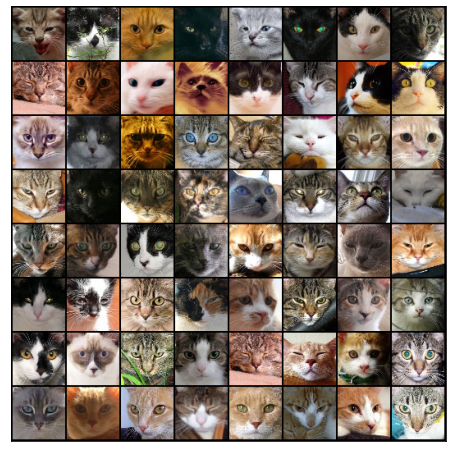

In [7]:
show_batch(train_dl)

In [8]:
def is_cuda_available():
    if torch.cuda.is_available():
        print("CUDA available. Training on GPU!")
        return torch.device('cuda')
    else:
        print("CUDA not available. Training on CPU!")
        return torch.device('cpu')


In [9]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [10]:
is_cuda_available()

CUDA available. Training on GPU!


device(type='cuda')

In [11]:
device=is_cuda_available()
train_dl = DeviceDataLoader(train_dl, device)

CUDA available. Training on GPU!


In [12]:
#basic cnn with convolutional layers and leaky relu as activation fn
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [13]:
discriminator = to_device(discriminator, device)

In [14]:
latent_size = 128
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


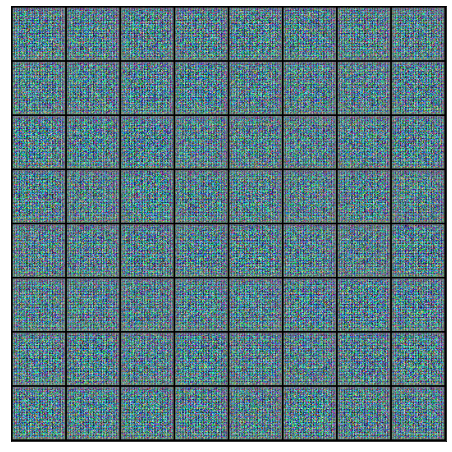

In [15]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [16]:
generator = to_device(generator, device)

In [17]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [18]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()


In [19]:

sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [20]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [21]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


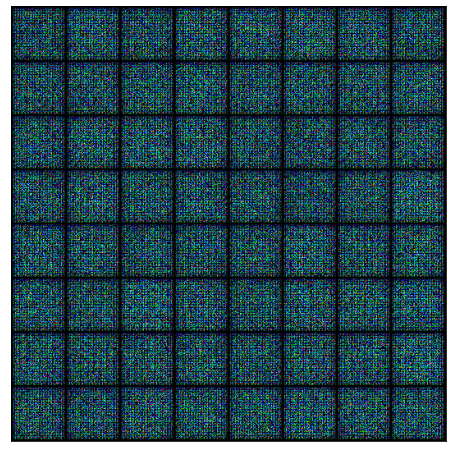

In [22]:
save_samples(0, fixed_latent)

In [23]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [24]:
lr = 0.0003
epochs = 60

In [25]:
history=fit(epochs,lr)


Epoch [1/60], loss_g: 2.4388, loss_d: 0.7396, real_score: 0.6939, fake_score: 0.2640
Saving generated-images-0001.png



Epoch [2/60], loss_g: 5.7402, loss_d: 0.7463, real_score: 0.9953, fake_score: 0.4723
Saving generated-images-0002.png



Epoch [3/60], loss_g: 4.1778, loss_d: 0.2783, real_score: 0.9196, fake_score: 0.1656
Saving generated-images-0003.png



Epoch [4/60], loss_g: 5.6940, loss_d: 0.9080, real_score: 0.9093, fake_score: 0.5071
Saving generated-images-0004.png



Epoch [5/60], loss_g: 5.5380, loss_d: 0.5413, real_score: 0.9669, fake_score: 0.3757
Saving generated-images-0005.png



Epoch [6/60], loss_g: 4.1812, loss_d: 1.3069, real_score: 0.2976, fake_score: 0.0037
Saving generated-images-0006.png



Epoch [7/60], loss_g: 1.1435, loss_d: 1.5589, real_score: 0.3479, fake_score: 0.1569
Saving generated-images-0007.png



Epoch [8/60], loss_g: 4.3309, loss_d: 0.2299, real_score: 0.9814, fake_score: 0.1774
Saving generated-images-0008.png



Epoch [9/60], loss_g: 3.7601, loss_d: 0.1849, real_score: 0.8530, fake_score: 0.0189
Saving generated-images-0009.png



Epoch [10/60], loss_g: 5.7255, loss_d: 0.2671, real_score: 0.9707, fake_score: 0.1946
Saving generated-images-0010.png



Epoch [11/60], loss_g: 5.1623, loss_d: 0.0325, real_score: 0.9936, fake_score: 0.0251
Saving generated-images-0011.png



Epoch [12/60], loss_g: 3.1361, loss_d: 1.3850, real_score: 0.3288, fake_score: 0.0040
Saving generated-images-0012.png



Epoch [13/60], loss_g: 5.7750, loss_d: 0.0652, real_score: 0.9849, fake_score: 0.0475
Saving generated-images-0013.png



Epoch [14/60], loss_g: 3.1639, loss_d: 0.5301, real_score: 0.6522, fake_score: 0.0147
Saving generated-images-0014.png



Epoch [15/60], loss_g: 7.1220, loss_d: 0.2911, real_score: 0.9642, fake_score: 0.1912
Saving generated-images-0015.png



Epoch [16/60], loss_g: 5.1182, loss_d: 0.2696, real_score: 0.8121, fake_score: 0.0330
Saving generated-images-0016.png



Epoch [17/60], loss_g: 2.8581, loss_d: 0.2099, real_score: 0.8613, fake_score: 0.0503
Saving generated-images-0017.png



Epoch [18/60], loss_g: 4.6206, loss_d: 0.1864, real_score: 0.9264, fake_score: 0.0961
Saving generated-images-0018.png



Epoch [19/60], loss_g: 4.8596, loss_d: 0.0597, real_score: 0.9767, fake_score: 0.0335
Saving generated-images-0019.png



Epoch [20/60], loss_g: 7.9535, loss_d: 0.1817, real_score: 0.9947, fake_score: 0.1504
Saving generated-images-0020.png



Epoch [21/60], loss_g: 7.4532, loss_d: 0.0737, real_score: 0.9340, fake_score: 0.0019
Saving generated-images-0021.png



Epoch [22/60], loss_g: 2.4640, loss_d: 1.1002, real_score: 0.5738, fake_score: 0.0790
Saving generated-images-0022.png



Epoch [23/60], loss_g: 2.8326, loss_d: 0.3244, real_score: 0.7696, fake_score: 0.0379
Saving generated-images-0023.png



Epoch [24/60], loss_g: 1.2818, loss_d: 2.3397, real_score: 0.1255, fake_score: 0.0005
Saving generated-images-0024.png



Epoch [25/60], loss_g: 7.0411, loss_d: 0.0204, real_score: 0.9978, fake_score: 0.0177
Saving generated-images-0025.png



Epoch [26/60], loss_g: 4.7996, loss_d: 0.3219, real_score: 0.9090, fake_score: 0.1813
Saving generated-images-0026.png



Epoch [27/60], loss_g: 3.7822, loss_d: 0.2238, real_score: 0.8335, fake_score: 0.0344
Saving generated-images-0027.png



Epoch [28/60], loss_g: 6.9974, loss_d: 0.1648, real_score: 0.8779, fake_score: 0.0018
Saving generated-images-0028.png



Epoch [29/60], loss_g: 1.3541, loss_d: 0.6095, real_score: 0.7000, fake_score: 0.1654
Saving generated-images-0029.png



Epoch [30/60], loss_g: 0.0293, loss_d: 1.4100, real_score: 0.3064, fake_score: 0.1355
Saving generated-images-0030.png



Epoch [31/60], loss_g: 0.0052, loss_d: 1.6293, real_score: 0.3009, fake_score: 0.0574
Saving generated-images-0031.png



Epoch [32/60], loss_g: 4.2626, loss_d: 0.1767, real_score: 0.8737, fake_score: 0.0277
Saving generated-images-0032.png



Epoch [33/60], loss_g: 3.0910, loss_d: 0.4914, real_score: 0.7927, fake_score: 0.1567
Saving generated-images-0033.png



Epoch [34/60], loss_g: 5.6624, loss_d: 0.2112, real_score: 0.9304, fake_score: 0.1128
Saving generated-images-0034.png



Epoch [35/60], loss_g: 4.2879, loss_d: 0.1843, real_score: 0.9369, fake_score: 0.1011
Saving generated-images-0035.png



Epoch [36/60], loss_g: 2.5593, loss_d: 0.2831, real_score: 0.8471, fake_score: 0.0533
Saving generated-images-0036.png



Epoch [37/60], loss_g: 3.2428, loss_d: 0.3686, real_score: 0.7378, fake_score: 0.0417
Saving generated-images-0037.png



Epoch [38/60], loss_g: 2.6740, loss_d: 0.2215, real_score: 0.8192, fake_score: 0.0195
Saving generated-images-0038.png



Epoch [39/60], loss_g: 3.5237, loss_d: 2.8083, real_score: 0.1802, fake_score: 0.0105
Saving generated-images-0039.png



Epoch [40/60], loss_g: 3.9115, loss_d: 0.2374, real_score: 0.9495, fake_score: 0.1524
Saving generated-images-0040.png



Epoch [41/60], loss_g: 4.1217, loss_d: 0.2209, real_score: 0.8843, fake_score: 0.0780
Saving generated-images-0041.png



Epoch [42/60], loss_g: 4.5449, loss_d: 0.2190, real_score: 0.8244, fake_score: 0.0071
Saving generated-images-0042.png



Epoch [43/60], loss_g: 5.2555, loss_d: 0.1334, real_score: 0.9969, fake_score: 0.1094
Saving generated-images-0043.png



Epoch [44/60], loss_g: 2.5278, loss_d: 0.2900, real_score: 0.8218, fake_score: 0.0473
Saving generated-images-0044.png



Epoch [45/60], loss_g: 1.4258, loss_d: 0.6389, real_score: 0.7581, fake_score: 0.0985
Saving generated-images-0045.png



Epoch [46/60], loss_g: 1.0527, loss_d: 0.4022, real_score: 0.7177, fake_score: 0.0540
Saving generated-images-0046.png



Epoch [47/60], loss_g: 0.9164, loss_d: 0.5927, real_score: 0.6753, fake_score: 0.0896
Saving generated-images-0047.png



Epoch [48/60], loss_g: 4.9504, loss_d: 0.1546, real_score: 0.9275, fake_score: 0.0664
Saving generated-images-0048.png



Epoch [49/60], loss_g: 2.7636, loss_d: 0.1537, real_score: 0.9406, fake_score: 0.0789
Saving generated-images-0049.png



Epoch [50/60], loss_g: 5.3796, loss_d: 0.0889, real_score: 0.9553, fake_score: 0.0389
Saving generated-images-0050.png



Epoch [51/60], loss_g: 4.7459, loss_d: 0.0595, real_score: 0.9756, fake_score: 0.0328
Saving generated-images-0051.png



Epoch [52/60], loss_g: 5.8837, loss_d: 0.1475, real_score: 0.9930, fake_score: 0.1173
Saving generated-images-0052.png



Epoch [53/60], loss_g: 4.2977, loss_d: 0.1122, real_score: 0.9371, fake_score: 0.0408
Saving generated-images-0053.png



Epoch [54/60], loss_g: 0.0199, loss_d: 0.9843, real_score: 0.4268, fake_score: 0.0591
Saving generated-images-0054.png



Epoch [55/60], loss_g: 4.5714, loss_d: 0.3040, real_score: 0.9141, fake_score: 0.1549
Saving generated-images-0055.png



Epoch [56/60], loss_g: 2.8747, loss_d: 0.2267, real_score: 0.8685, fake_score: 0.0737
Saving generated-images-0056.png



Epoch [57/60], loss_g: 1.8265, loss_d: 3.8816, real_score: 0.4760, fake_score: 0.3010
Saving generated-images-0057.png



Epoch [58/60], loss_g: 5.6970, loss_d: 0.0932, real_score: 0.9945, fake_score: 0.0791
Saving generated-images-0058.png



Epoch [59/60], loss_g: 1.7243, loss_d: 0.2916, real_score: 0.7927, fake_score: 0.0342
Saving generated-images-0059.png



Epoch [60/60], loss_g: 1.0437, loss_d: 0.8685, real_score: 0.5872, fake_score: 0.0152
Saving generated-images-0060.png


In [26]:
losses_g, losses_d, real_scores, fake_scores = history

In [27]:
from IPython.display import Image

One Fake generated image:

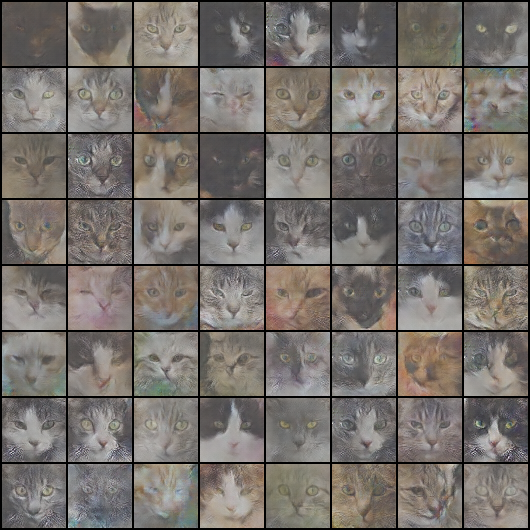

In [28]:
Image('./generated/generated-images-0033.png')

In [29]:

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

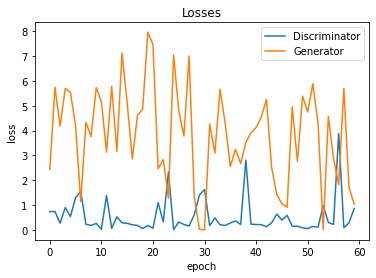

In [30]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

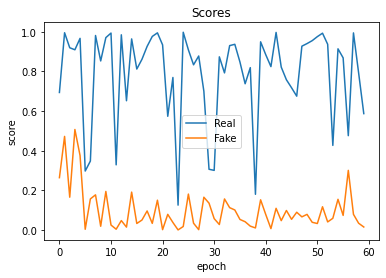

In [31]:

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

Saving generated-images-0000.png


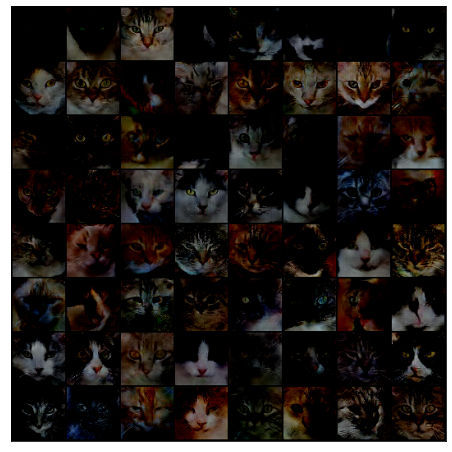

In [32]:
save_samples(0, fixed_latent)